In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
complex_data = pd.read_csv('complexity_data.csv')
info_data = pd.read_csv('filter_repos_with_language.csv')
data = complex_data.merge(info_data, on='repo_name', how='left').reset_index(drop=True)

In [3]:
display(data.head(4))

,repo_name,loc,cyclomatic_complexity,cognitive_complexity,size,_id,filename,html_url,star_count,fork_count,...,pushed_at,num_commits,num_committers,num_issues,num_issues_submitters,num_issues_comments,num_issues_commenters,num_gov_commits,num_gov_committers,language
0,grpc/grpc-go,204065.0,29406.0,28783.0,40272,62547e91a67705b3d7ed9db7,GOVERNANCE.md,https://github.com/grpc/grpc-go/blob/87eb5b750...,15416,3444,...,2022-02-24 1:29:33,4120,330,1887,1050,5594,983,1,1,Go
1,grpc/grpc-java,337955.0,23715.0,225017.0,103468,62547e91a67705b3d7ed9db8,GOVERNANCE.md,https://github.com/grpc/grpc-java/blob/d4fa0ec...,9455,3255,...,2022-02-23 21:56:47,5264,274,2843,1164,9056,1094,1,1,Java
2,google/gvisor,495008.0,98655.0,85395.0,92516,62547e91a67705b3d7ed9dbd,GOVERNANCE.md,https://github.com/google/gvisor/blob/10841063...,12465,1024,...,2022-02-24 3:26:00,6541,188,1335,298,2308,336,1,1,Go
3,appium/appium,43373.0,7513.0,3611.0,200764,62547e91a67705b3d7ed9dc2,GOVERNANCE.md,https://github.com/appium/appium/blob/1e30207e...,14740,5507,...,2022-02-23 23:47:20,7356,369,12328,5496,61385,6480,6,4,JavaScript


# 1: Data Cleaning & Feature Engineering

In [4]:
import pandas as pd
import pytz
import numpy as np
from datetime import datetime

def preprocess_data(df):
    """
    Perform comprehensive preprocessing for OSS sustainability analysis
    
    Parameters:
    df (pd.DataFrame): Raw input dataframe with columns as specified
    
    Returns:
    pd.DataFrame: Preprocessed dataframe ready for modeling
    """
    
    # Convert to datetime objects first to prevent comparison errors
    df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
    df['pushed_at'] = pd.to_datetime(df['pushed_at'], utc=True)
    last_time = df['pushed_at'].max()
    
    # ========================================================================
    # 1. Time Feature Engineering
    # ========================================================================
    
    # Binary indicator for recent activity (target variable 1)
    # Rationale: Projects without updates in 15 days are considered inactive
    df['is_active'] = (last_time - df['pushed_at']) < pd.Timedelta(days=15)
    df['is_active'] = df['is_active'].astype(int) 
    
    # Project age in days 
    # Rationale: Older projects have different sustainability patterns
    df['project_age'] = (last_time - df['created_at']).dt.days
    
    # Days since last update
    # Rationale: Recent activity decay might signal abandonment risk
    df['last_update_interval'] = (last_time - df['pushed_at']).dt.days
    
    # ========================================================================
    # 2. Target Variable Construction
    # ========================================================================
    
    # Community growth rate (target variable 2)
    # Rationale: Normalizes popularity metrics by project lifetime
    df['growth_rate'] = (df['star_count'] + df['fork_count']) / df['project_age']
    
    # Filter new projects with insufficient history
    # Rationale: Projects <30 days old have unstable metrics
    # df = df[df['project_age'] >= 30]
    
    # ========================================================================
    # 3. Missing Value Treatment
    # ========================================================================
    
    # Handle governance commits missingness
    # Rationale: Absence of governance commits implies zero governance activity
    df['num_gov_commits'] = df['num_gov_commits'].fillna(0)
    
    # Handle missing programming languages
    # Rationale: Language is crucial for tech stack analysis, cannot be imputed    
    top_languages = df['language'].value_counts().nlargest(5).index
    df['language'] = np.where(df['language'].isin(top_languages), 
                             df['language'], 
                             'Other')
    df['language'] = df['language'].fillna('Other')
    
    # ========================================================================
    # 4. Feature Transformations
    # ========================================================================
    
    # Logarithmic transform for skewed distributions
    # Rationale: Reduces right-skewness in codebase size metrics
    log_columns = ['loc', 'num_commits', 'num_issues']
    for col in log_columns:
        df[f'log_{col}'] = np.log1p(df[col])
        
    # Complexity binning using quantiles
    # Rationale: Non-linear relationships with sustainability metrics
    df['cyclomatic_complexity_bin'] = pd.qcut(
        df['cyclomatic_complexity'],
        q=[0, 0.33, 0.66, 1],
        labels=['low', 'medium', 'high'],
        duplicates='drop'  # 添加重复分位数处理
    ).cat.add_categories('unknown').fillna('unknown')  # 处理缺失值
    df = df.dropna()
    # ========================================================================
    # Final Validation
    # ========================================================================
    
    # Check for remaining missing values
    assert df.isnull().sum().sum() == 0, "Missing values detected in final data"
    
    # Ensure logical consistency
    assert (df['last_update_interval'] >= 0).all(), "Negative update interval"
    assert (df['project_age'] >= 30).all(), "Invalid project age filtering"
    
    return df

data = preprocess_data(data)


In [5]:
def feature_engineering(df):
    """
    Perform advanced feature engineering for OSS sustainability prediction
    
    Parameters:
    df (pd.DataFrame): Preprocessed dataframe from previous stage
    
    Returns:
    pd.DataFrame: Enhanced dataframe with engineered features
    """
    
    # ========================================================================
    # 1. Static Feature Construction
    # ========================================================================
    
    # Code Quality Features
    # Rationale: Normalize complexity metrics by codebase size
    df['complexity_per_line'] = df['cognitive_complexity'] / (df['loc'] + 1e-6)         
    df['test_coverage'] = df['num_gov_commits'] / (df['num_commits'] + 1e-6) 
    
    # Community Health Features
    # Rationale: Measure contributor engagement patterns
    df['committer_diversity'] = df['num_committers'] / (df['num_commits'] + 1e-6)
    df['issue_resolution_ratio'] = df['num_issues_comments'] / (df['num_issues'] + 1e-6) 
    
    # ========================================================================
    # 2. Temporal Feature Engineering 
    # ========================================================================
    
    # Recent Activity Intensity (requires time-series commit data)
    # Assumption: 'num_commits' contains 30-day commit count (adapt based on real data)
    df['recent_commits_ratio'] = df['num_commits'] / (df['num_commits'].rolling(30).sum().fillna(0) + 1e-6)
    
    # Growth Momentum (requires historical star tracking)
    # Placeholder implementation - needs time-series data
    df['growth_acceleration'] = df['star_count'].pct_change(periods=1).fillna(0)
    
    # ========================================================================
    # 3. Interaction Features
    # ========================================================================
    
    # Language-Complexity Interaction
    # Rationale: Different languages have different complexity tolerance
    df['lang'] = df['language']
    df = pd.get_dummies(df, columns=['lang'], prefix='lang')
    for col in df.filter(like='lang_').columns:
        df[f'{col}_complexity'] = df[col] * df['cognitive_complexity']
    
    df = pd.get_dummies(df, 
                      columns=['cyclomatic_complexity_bin'], 
                      prefix='complexity',
                      drop_first=True)
    
    # Resource Allocation Ratio
    # Rationale: Measures scaling efficiency of contributor base
    df['size_committer_ratio'] = df['size'] / (df['num_committers'] + 1e-6)
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

data = feature_engineering(data)

# EDA

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

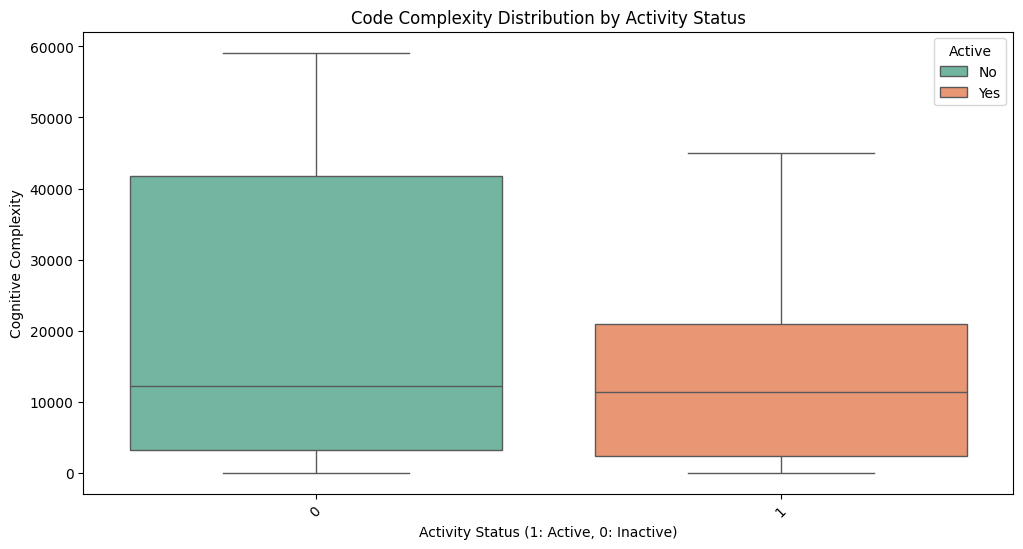

In [7]:
# -----------------------------------------------------------
# Visualization 1: Code Complexity vs Project Activity
# -----------------------------------------------------------
# Motivation: Validate if higher code complexity correlates with inactive status
# Hypothesis: Projects with high cognitive complexity are more likely to become inactive
df = data.copy()
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_active', y='cognitive_complexity', hue='is_active',
            data=df, showfliers=False,
            palette="Set2", width=0.8)
plt.title('Code Complexity Distribution by Activity Status')
plt.xlabel('Activity Status (1: Active, 0: Inactive)')
plt.ylabel('Cognitive Complexity')
plt.legend(title='Active', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()
    

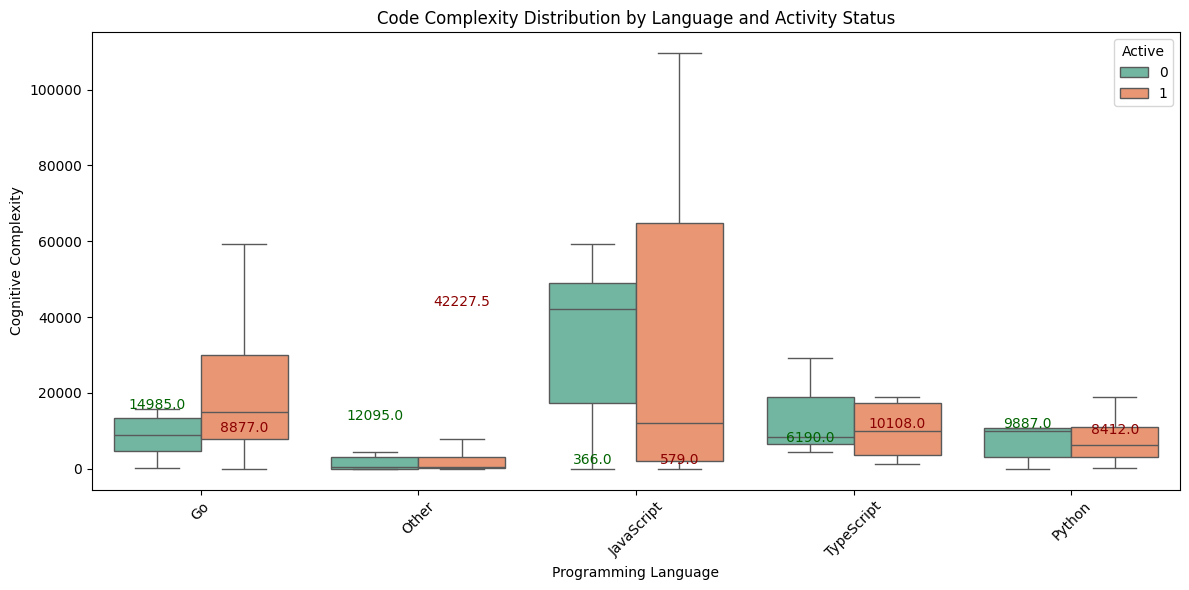

In [8]:
# -----------------------------------------------------------
# Visualization 2: Language-Specific Complexity Thresholds
# -----------------------------------------------------------\
"""
Motivation: Identify language-specific complexity thresholds for sustainability
Hypothesis: Different languages have different acceptable complexity levels
"""
plt.figure(figsize=(12, 6))

# Filter top 5 languages
top_langs = df['language'].value_counts().nlargest(5).index
filtered_df = df[df['language'].isin(top_langs)]

# Boxplot with activity status
sns.boxplot(x='language', y='cognitive_complexity', hue='is_active',
        data=filtered_df, showfliers=False,
        palette="Set2", width=0.8)

plt.title('Code Complexity Distribution by Language and Activity Status')
plt.xlabel('Programming Language')
plt.ylabel('Cognitive Complexity')
plt.legend(title='Active', loc='upper right')
plt.xticks(rotation=45)

# Add median labels
for i, lang in enumerate(top_langs):
        med_active = filtered_df[(filtered_df['language']==lang) & 
                                (filtered_df['is_active']==1)]['cognitive_complexity'].median()
        med_inactive = filtered_df[(filtered_df['language']==lang) & 
                                        (filtered_df['is_active']==0)]['cognitive_complexity'].median()
        plt.text(i-0.2, med_active+2, f'{med_active:.1f}', 
                ha='center', va='bottom', color='darkgreen')
        plt.text(i+0.2, med_inactive+2, f'{med_inactive:.1f}', 
                ha='center', va='bottom', color='darkred')

plt.tight_layout()
plt.show()

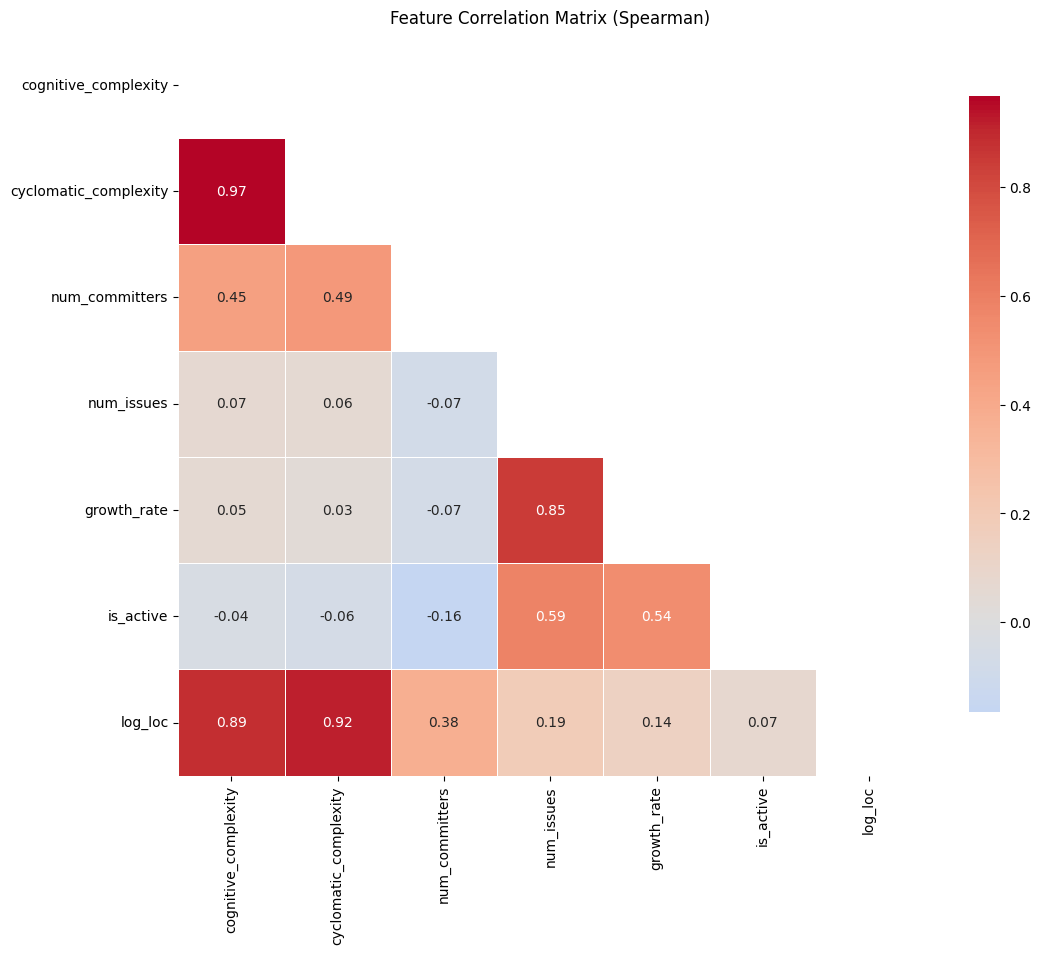

In [9]:
# -----------------------------------------------------------
# Visualization 3: Feature Correlation Matrix
# -----------------------------------------------------------
"""
Motivation: Identify multicollinearity between predictive features
Hypothesis: Some code metrics and community metrics are highly correlated
"""
# Select key features
features = ['cognitive_complexity', 'cyclomatic_complexity', 
            'num_committers', 'num_issues', 'growth_rate',
            'is_active', 'log_loc']

plt.figure(figsize=(12, 10))

# Compute correlation matrix
corr = df[features].corr(method='spearman')

# Generate mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
            cmap="coolwarm", center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('Feature Correlation Matrix (Spearman)')
plt.show()

# Model Training


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import (
    roc_auc_score, f1_score, average_precision_score,
    r2_score, mean_absolute_error
)
import shap
import matplotlib.pyplot as plt

def train_activity_model(X, y):
    """
    Train and evaluate activity prediction models (Binary Classification)
    
    Parameters:
    X (pd.DataFrame): Feature matrix
    y (pd.Series): is_active labels
    
    Returns:
    dict: Model performance metrics
    """
    # Temporal split validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Define models
    models = {
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(max_iter=1000))
        ]),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'XGBoost': XGBClassifier(eval_metric='logloss'),
    }
    
    results = {}
    
    for name, model in models.items():
        metrics = {'auc': [], 'f1': [], 'prc': []}
        print('training model: ', name)
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            probas = model.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            metrics['auc'].append(roc_auc_score(y_test, probas))
            metrics['f1'].append(f1_score(y_test, (probas > 0.5).astype(int)))
            metrics['prc'].append(average_precision_score(y_test, probas))
            
        results[name] = {
            'AUC-ROC': np.mean(metrics['auc']),
            'F1-Score': np.mean(metrics['f1']),
            'PR-AUC': np.mean(metrics['prc'])
        }
        
        # SHAP analysis for best tree-based model
        if 'Forest' in name or 'XGB' in name:
            explainer = shap.TreeExplainer(model.named_steps['model'] if isinstance(model, Pipeline) else model)
            shap_values = explainer.shap_values(X_test)
            
            plt.figure()
            if len(shap_values) == 2:  # 二分类情况
                shap_values = shap_values[1]  # 取正类的SHAP值

            shap.summary_plot(
                shap_values, 
                X_test, 
                plot_type="dot",  # 更清晰的分类可视化
                max_display=10,
                show=False  # 避免自动显示导致的错位
            )
            plt.title(f"{name} Feature Impact")
            plt.tight_layout()  # 修复布局
            plt.show()
    
    return results


数据准备完成：
- 活跃度预测：31 特征，176 样本

训练活跃度预测模型...
training model:  Logistic Regression
training model:  Random Forest


<Figure size 640x480 with 0 Axes>

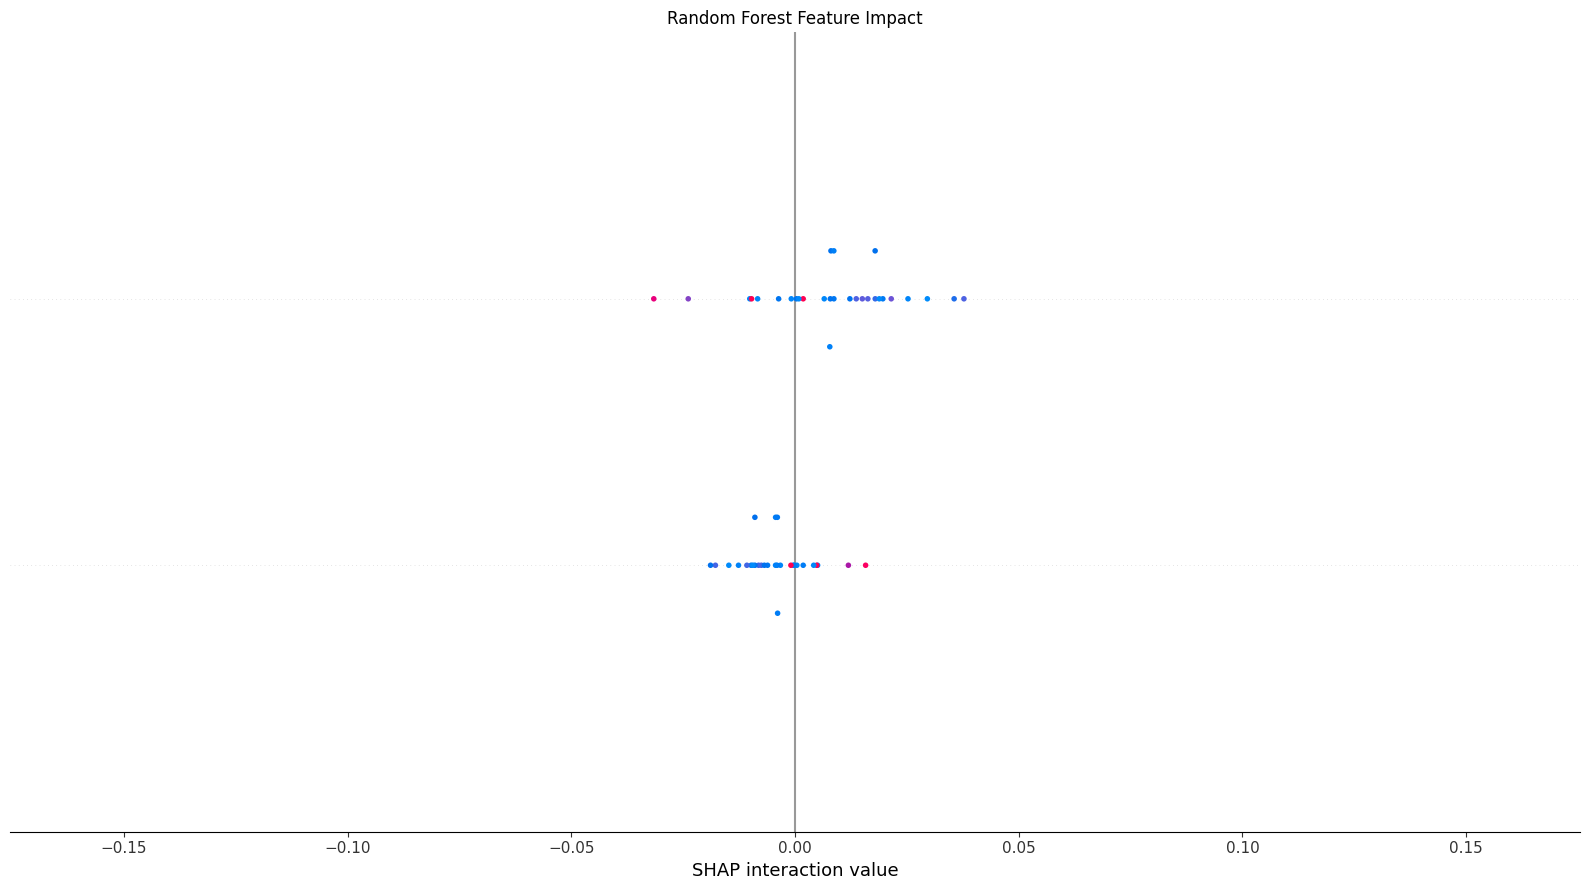

training model:  XGBoost


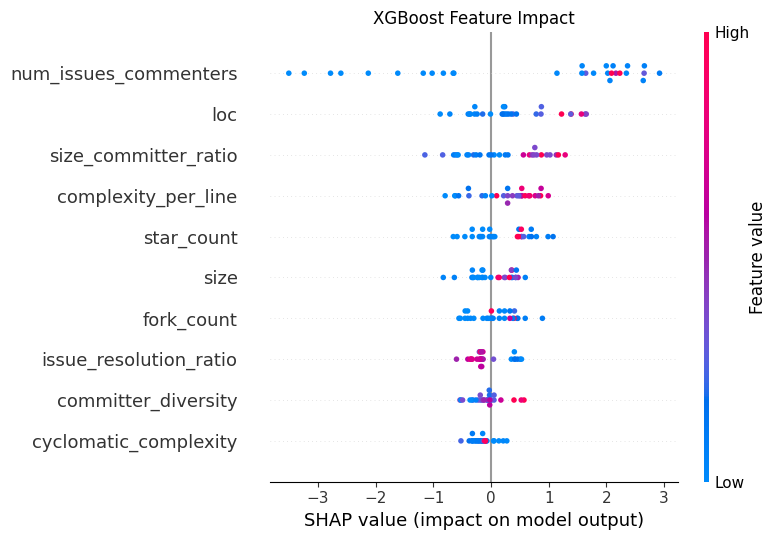

{'Logistic Regression': {'AUC-ROC': 0.7197165579518521, 'F1-Score': 0.7617249417249418, 'PR-AUC': 0.8117564520623646}, 'Random Forest': {'AUC-ROC': 0.7741322403087109, 'F1-Score': 0.8299080258786502, 'PR-AUC': 0.8431840336592138}, 'XGBoost': {'AUC-ROC': 0.7790743570155335, 'F1-Score': 0.7961553577114218, 'PR-AUC': 0.8635236768462748}}


In [11]:
activity_data = data.copy()
irrelevant_features = ['repo_name', '_id', 'filename', 'html_url', 'language']
time_related_features = ['created_at', 'updated_at', 'pushed_at', 'project_age', 'last_update_interval', 'num_committers',
                        'num_issues', 'num_issues_comments', 'num_gov_commits', 'growth_acceleration', 
                          'num_issues_submitters', 'log_num_commits', 'log_num_issues']
X_active = activity_data.drop(columns=irrelevant_features + time_related_features + ['growth_rate', 'is_active'])
y_active = activity_data['is_active']

print("\n数据准备完成：")
print(f"- 活跃度预测：{X_active.shape[1]} 特征，{len(y_active)} 样本")
print("\n训练活跃度预测模型...")
activity_metrics = train_activity_model(X_active, y_active)
print(activity_metrics)
